### Project: Classifying English sentences into simple / complex / compound / complex-compound
- Result: Count of actual inputs: 288, Accuracy: 0.9513888888888888

### 아이디어 설명
0. 태스크: sentence type을 simple / complex / compound / complex-compound로 분류하는 것
1. 해결 아이디어: Rule-based
- why Rule-based?: 데이터셋이 충분하지 않음 & 문장 형식 기반으로 type을 구분하는 기준이 꽤 명확한 편임 -> 자연어처리 모듈을 활용할 경우 Rule-base로도 높은 정확도로 해결될 것이라 판단
- 문장을 절 단위로 구분
- 문장을 구성하는 독립절, 종속절의 개수를 파악
- 독립절 1개: simple, 독립절 1개와 종속절 2개 이상: complex, 독립절 2개 이상: compound, 독립절 2개 이상과 종속절 1개 이상: complex-compound

2. 데이터셋 마련:
- 인터넷 검색을 통한 데이터 크롤링 & chatgpt를 통해 생성 -> 약 290개의 데이터
3. 태스크 성격에 따라, 각 텍스트에 의미론적(semantic)으로 접근하기보다, 형식적(syntactic)으로 접근하는 것이 맞다고 판단함.
- 이에 따라 원본 텍스트 형식을 훼손하는 전처리를 지양함.
- 문장 내에서 각 토큰 간 dependency를 파악하고, 각 문장의 syntactic analysis을 기반으로 Constituent의 hierarchy tree를 생성하여 종속절 유무를 파악함
4. 사용 라이브러리: spacy & constituent_treelib
- spacy.load("en_core_web_sm"), token.dep_를 통해 각 문장을 구성하는 토큰의 dependency를 분석
- constituent_treelib(CTL): Lightweight Python library to parse sentences into constituent trees, Built on top of benepar (Berkeley Neural Parser) as well as the two well-known NLP frameworks spaCy and NLTK.
- https://github.com/Halvani/Constituent-Treelib


5. 구현:
- constituent_tree 기반으로 'SBAR'를 활용하여 종속절 유무 파악
- 원본 문장에서 종속절을 제거한 후 남은 문장에서, 절의 주어 개수를 기준으로(if token.dep_ in ['nsubj', 'nsubjpass', 'csubj', 'csubjpass']) 독립절 개수 파악
- 명령문 케이스 별도 처리
- There 유도부사 도치구문 케이스 별도 처리

### Setting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [ ]:
%cd '/content/drive/MyDrive/ML'

In [ ]:
label_files = {
    1: 'dataset/label1.txt',
    2: 'dataset/label2.txt',
    3: 'dataset/label3.txt',
    4: 'dataset/label4.txt'
}

In [ ]:
for i in range(1,5):
    with open(label_files[i], 'r') as file:
        print(np.array([line.strip() for line in file]).shape)

(71,)
(92,)
(81,)
(47,)


In [ ]:
#Initiate DataFrame
all_data = pd.DataFrame(columns=['text', 'label'])

# read file
for label, file_path in label_files.items():
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    lines = [line.strip() for line in lines] #줄바꿈 없애기
    label_data = pd.DataFrame({'text': lines, 'label': label})

    all_data = pd.concat([all_data, label_data], ignore_index=True)

# submit as CSV file
all_data.to_csv('dataset/data_set.csv', index=False)

In [ ]:
df = pd.read_csv('dataset/data_set.csv')

X = df['text']
y = df['label']
y[1:] = y[1:].astype(int)

In [ ]:
!pip install packaging==21.3

In [ ]:
!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install uvicorn
!pip install setuptools

In [ ]:
!pip install constituent-treelib

In [ ]:
!pip install packaging==21.3

In [ ]:
!pip install LegacyVersion

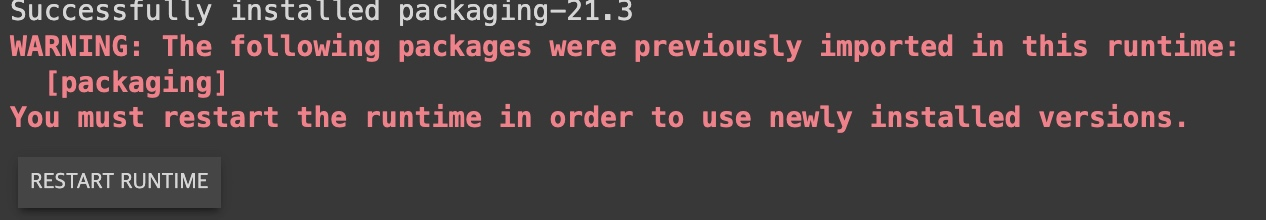

상단 !pip install 모두 실행한 후 사진에 해당하는 warning 뜬 경우, 'restart runtime' 누른 후 pip install 코드 뛰어 넘고 바로 import 하면 됨

### Main Algorithm

In [ ]:
import spacy
from constituent_treelib import ConstituentTree, Language
from tqdm import tqdm

In [ ]:
parse = spacy.load("en_core_web_sm")

In [ ]:
# Define the language (underlying benepar and spaCy models)
language = Language.English
spacy_model_size = ConstituentTree.SpacyModelSize.Medium

# neccesary NLP pipeline that is required to instantiate a ConstituentTree object
nlp = ConstituentTree.create_pipeline(language, spacy_model_size)

The spaCy model: 'en_core_web_md' was not found. Download is initiated...
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package benepar_en3 to /usr/share/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def remove_sentence_a_from_b(sentence_a, sentence_b):
    result = sentence_b.replace(sentence_a, '').strip()
    return result

In [ ]:
def SBAR_remove(all_phrases, sentence):
    removed = sentence
    for i in range(len(all_phrases['SBAR'])):
        removed = remove_sentence_a_from_b(all_phrases['SBAR'][i], removed)
    return removed

In [ ]:
accuracy = 0
cnt = 0
for index, text_data in tqdm(list(X.items())[1:]):
    try:
        tree = ConstituentTree(text_data, nlp)
        all_phrases = tree.extract_all_phrases()

        #count dependent clauses
        if 'SBAR' in all_phrases.keys():
            indep_only = SBAR_remove(all_phrases,text_data)
            dep_cnt = True

        else:
            indep_only = text_data
            dep_cnt = False

        #dependency analysis of independent clauses
        indep_parsed = parse(indep_only)

        #count independent clauses
        indep_cnt = 0

        if indep_parsed[0].dep_ == 'ROOT': #명령문 별도 처리
            indep_cnt += 1

        for token in indep_parsed:
            if (token.dep_ in ['nsubj', 'nsubjpass', 'csubj', 'csubjpass']) or (token.tag_ == 'EX'): #절의 주어 및 existential there의 개수에 따라 독립문 개수 처리
                indep_cnt += 1


        '''predict'''
        if not dep_cnt:
            if indep_cnt<=1:
                pred = 1 #simple

            else:
                pred = 3 #compound

        elif dep_cnt:
            if indep_cnt<=1:
                pred = 2 #complex

            else:
                pred = 4 #complex-compound

        '''evaluate'''
        cnt += 1
        if pred == y[index]:
            accuracy +=1

        else: #for the incorrect prediction
            print(text_data, " pred:", pred, " label:", y[index])
            for token in indep_parsed:
                print(token.text, token.dep_)

            print("\n")


    except: #when encoding error happened
        continue

accuracy /= cnt
print(accuracy)

 12%|█▏        | 34/290 [00:04<00:38,  6.57it/s]

Flowers need sunlight to grow.  pred: 3  label: 1
Flowers nsubj
need ROOT
sunlight nsubj
to aux
grow ccomp
. punct




 18%|█▊        | 52/290 [00:07<00:43,  5.48it/s]

I feel happy when buying new clothes.  pred: 2  label: 1
I nsubj
feel ROOT
happy acomp
. punct


While jogging, he found a lost puppy.  pred: 2  label: 1
, punct
he nsubj
found ROOT
a det
lost amod
puppy dobj
. punct




 24%|██▍       | 69/290 [00:10<00:40,  5.50it/s]

There was nothing inherently difficult with getting the project done.  pred: 3  label: 1
There expl
was ROOT
nothing attr
inherently advmod
difficult amod
with prep
getting pcomp
the det
project nsubj
done ccomp
. punct




 31%|███       | 90/290 [00:12<00:25,  7.74it/s]

Since he didn't have a car, he commuted to work using public transport.  pred: 4  label: 2
Since mark
he nsubj
did aux
n't neg
have advcl
a det
car dobj
, punct
he nsubj
commuted ROOT
to aux
work xcomp
using xcomp
public amod
transport dobj
. punct




 35%|███▍      | 101/290 [00:14<00:23,  7.94it/s]

Even though it was her birthday, she spent it working on a project.  pred: 4  label: 2
, punct
she nsubj
spent ROOT
it nsubj
working ccomp
on prep
a det
project pobj
. punct




 44%|████▍     | 129/290 [00:17<00:19,  8.33it/s]

He went to the store after realizing he was out of milk.  pred: 3  label: 2
He nsubj
went ROOT
to prep
the det
store pobj
after prep
realizing pcomp
he nsubj
was ccomp
out prep
of prep
milk pobj
. punct




 53%|█████▎    | 153/290 [00:20<00:24,  5.59it/s]

While I was careful to observe my surroundings, I almost tripped walking up to my door since I couldn’t see in the darkness.  pred: 4  label: 2
, punct
I nsubj
almost advmod
tripped ROOT
walking xcomp
up prt
to prep
my poss
door pobj
since mark
I nsubj
could aux
n’t neg
see advcl
in prep
the det
darkness pobj
. punct




 55%|█████▌    | 160/290 [00:22<00:25,  5.19it/s]

The students, whatever their skill levels, all showed improvement.  pred: 4  label: 2
The det
students nsubj
, punct
, punct
all nsubj
showed ROOT
improvement dobj
. punct




 56%|█████▌    | 162/290 [00:22<00:27,  4.61it/s]

If you can imagine a furry humanoid seven feet tall, with the face of an intelligent gorilla and the braincase of a man, you'll have a rough idea of what they looked like  pred: 4  label: 2
If mark
you nsubj
can aux
imagine advcl
a det
furry dobj
humanoid appos
seven nummod
feet npadvmod
tall oprd
, punct
with prep
the det
face pobj
of prep
an det
intelligent amod
gorilla pobj
and cc
the det
braincase conj
of prep
a det
man pobj
, punct
you nsubj
'll aux
have ROOT
a det
rough amod
idea dobj
of prep




 61%|██████    | 176/290 [00:25<00:21,  5.26it/s]

The Angel Falls waterfall in Venezuela plunges 907 meters; it looks spectacular.  pred: 1  label: 3
The det
Angel compound
Falls compound
waterfall dep
in prep
Venezuela compound
plunges pobj
907 nummod
meters appos
; punct
it nsubj
looks ROOT
spectacular acomp
. punct




 62%|██████▏   | 179/290 [00:25<00:20,  5.52it/s]

Call us next week; it should be in then.  pred: 1  label: 3
Call advcl
us dobj
next amod
week npadvmod
; punct
it nsubj
should aux
be ROOT
in prep
then pcomp
. punct




 68%|██████▊   | 197/290 [00:28<00:12,  7.31it/s]

Power tends to corrupt, and absolute power corrupts absolutely.  pred: 1  label: 3
Power nsubj
tends ROOT
to aux
corrupt xcomp
, punct
and cc
absolute amod
power compound
corrupts conj
absolutely advmod
. punct




100%|██████████| 290/290 [00:47<00:00,  6.06it/s]

I’m going back to that restaurant, so I can order what I really want.  pred: 2  label: 4
I nsubj
’m aux
going ROOT
back advmod
to prep
that det
restaurant pobj
, punct
. punct


0.9513888888888888


In [ ]:
print(f"Count of actual inputs: {cnt}, Accuracy: {accuracy}")

Count of actual inputs: 288, Accuracy: 0.9513888888888888


## 논의 사항

### 1. 문법적으로 애매한 부분들 존재
0. 문법적으로, simple / complex / compound 분류하기 모호한 케이스 존재함 (명확히 정의하는 것이 필요함)  
ex) He went to the store after realizing he was out of milk.

**<현재 알고리즘에서 전제하는 규칙>**

1. 동일한 주어, 등위접속사 통해 서술어를 나열한 경우  
→ compound가 아닌, simple sentence로 간주
2. 분사구문은 부사절(clause)을 부사구(phrase)로 만든 형태로, 복문을 단문으로 변환시킬 때 자주 사용하는 컨셉.  
→  즉 독립절에 분사구문이 추가된 경우 simple sentence로 간주  

### 2. 모델 한계
- 데이터의 한계: 서비스 현장에서 input이 어떠한 형식으로, 어떠한 비율로 들어오는지에 따라 accuracy 달라질 것으로 예상
- ConstituentTree나 Spacy가 'SBAR(종속접속사, subordinating conjunction)'나 절의 주어('nsubj', 'nsubjpass', 'csubj', 'csubjpass')를 잘못 인식한 경우 에러 발생  
ex) Age shall not weary them, nor the years condemn.  
- 고유명사를 주어로 인식하지 못함  
ex) The Angel Falls waterfall in Venezuela plunges 907 meters; it looks spectacular.  
- 분사구문을 종속절로 볼지, 부사구로 볼지에 따라 알고리즘이 달라짐. 현재 알고리즘은 부사구로 해석하도록 Prior를 설정. 그러나, ConstituentTree가 분사구문 앞의 접속사를 SBAR로 인식하는 경우 오답 발생  
- 명령문의 첫 번째 서술어가 'ROOT'로 인식되지 않을 경우 오답 발생  
   ex) Call us next week; it should be in then.   

#### 3. 비고
- 입력 텍스트 인코딩에 문제가 생겼을 경우 try - except로 처리함
- 명령문의 경우 독립절로 처리해야 하지만, 설계한 알고리즘이 절의 주어를 기준으로 독립절을 판별하므로, 명령문 한정하여 별도 처리함
- There 유도부사 도치구문 (There is ~, There are ~, etc.)에서 절의 주어를 찾지 못하는 경향이 있어, 해당 코너케이스에 대해 'token.tag_ == 'EX''통해 별도 처리함
- 데이터셋을 더 충분히 확보했다면, 데이터 전처리 거친 후(clause 구분과 관련된 요소만 남기기) Bert 파인튜닝 시도해볼 것 같음



## References:

*Domain knowlege*
- https://www.grammarly.com/blog/simple-sentence/
- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9774397
- https://www.houstonisd.org/cms/lib2/TX01001591/Centricity/Domain/26063/CLASSIFYING%20SENTENCES%20-%20STUDY%20GUIDE.pdf

*Tools & References to help classifying sentence types*
- https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
- https://www.nltk.org/_modules/nltk/parse/corenlp.html
- https://github.com/Halvani/Constituent-Treelib/blob/main/README.md
- https://downloads.cs.stanford.edu/nlp/software/dependencies_manual.pdf
- https://spacy.io/usage/linguistic-features
- https://www.nltk.org/book/ch08.html#fig-ic-diagram
- https://www.tutorialspoint.com/natural_language_processing/natural_language_processing_syntactic_analysis.htm
- https://www.nltk.org/book_1ed/ch08-extras.html

